# Introduction

H-1B visa

In [33]:
# Import libraries and check the versions
import pandas as pd
import sys
import numpy as np
import sklearn
import matplotlib as mpl
import seaborn as sns
import missingno as msno

print('Python version: {}'.format(sys.version))
print('Numpy version {}'.format(np.__version__))
print('Pandas version {}'.format(pd.__version__))
print('Matplotlib version {}'.format(mpl.__version__))
print('Seaborn version {}'.format(sns.__version__))
print('Sklearn version: {}'.format(sklearn.__version__))
print('Missingno version: {}'.format(msno.__version__))

# Pretty display for notebooks
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# for more clear plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Python version: 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version 1.14.0
Pandas version 0.20.3
Matplotlib version 2.1.2
Seaborn version 0.8.0
Sklearn version: 0.19.1
Missingno version: 0.3.5


### 1. Data Collection

This dataset can be found at kaggle's website. First column of the dataset is the index column and we specify that with index_col = 0. Let's see the first five records of the dataset.

In [34]:
# retrieve the data
df = pd.read_csv('h1b_kaggle.csv', index_col=0)
df.head()

/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,"36,067.00","2,016.00","ANN ARBOR, MICHIGAN",-83.74,42.28
2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,"242,674.00","2,016.00","PLANO, TEXAS",-96.70,33.02
3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,"193,066.00","2,016.00","JERSEY CITY, NEW JERSEY",-74.08,40.73
4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,"220,314.00","2,016.00","DENVER, COLORADO",-104.99,39.74
5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,"157,518.40","2,016.00","ST. LOUIS, MISSOURI",-90.20,38.63


### 2. Data Wrangling

Before we do explonatary data analysis, we need to select necessary features and clean the data. 

In [35]:
# select the features that will be used creating the model
data = df[['CASE_STATUS', 'SOC_NAME',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'WORKSITE']]

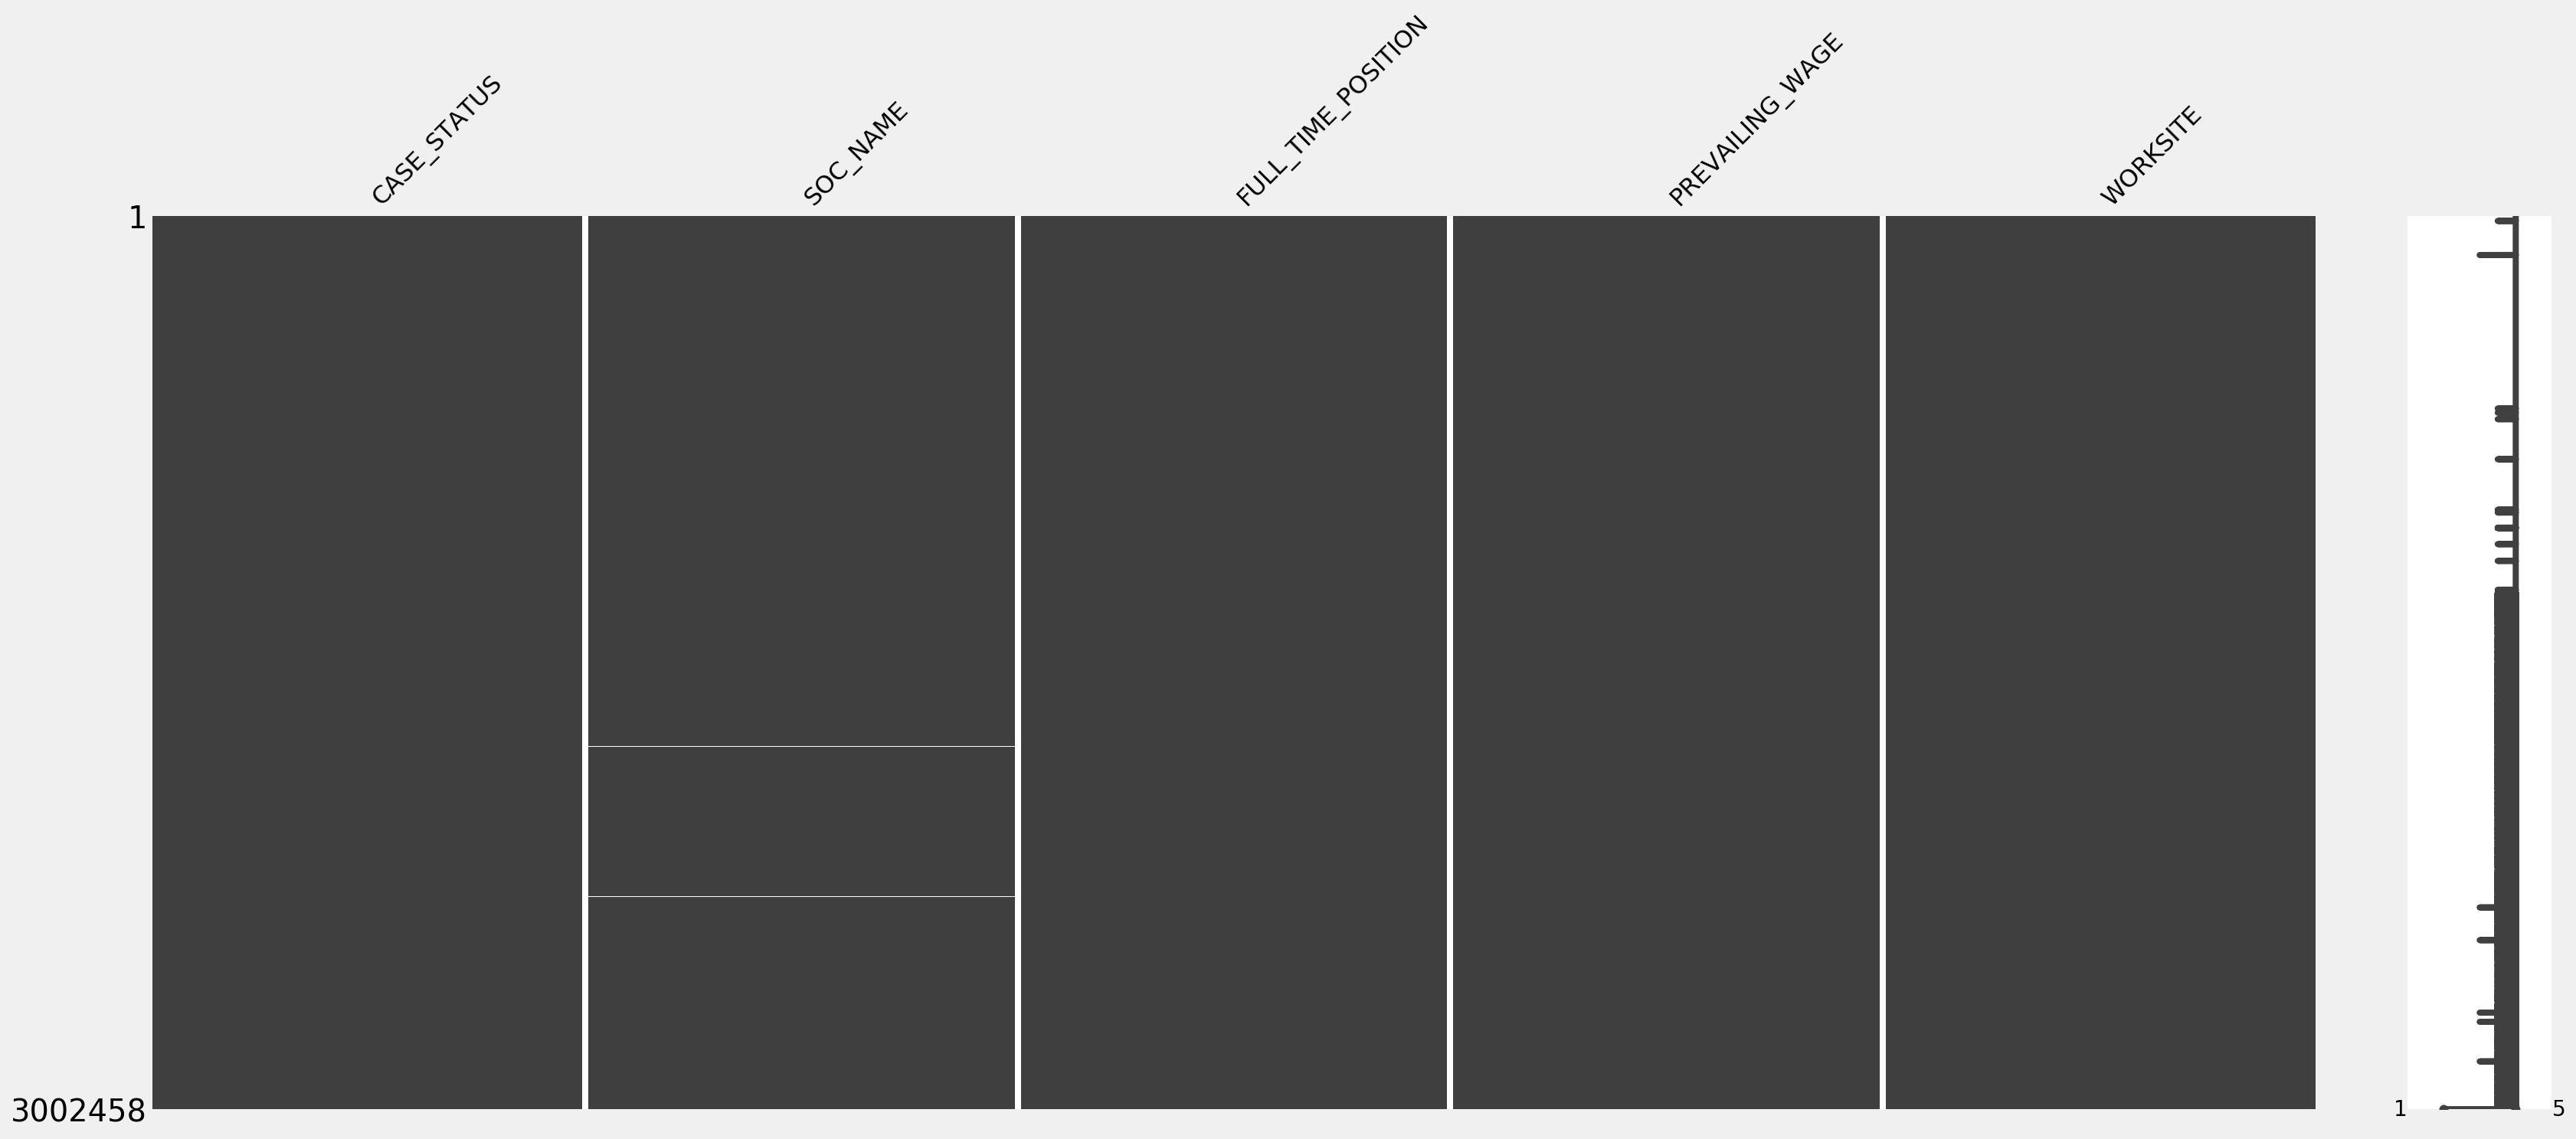

In [36]:
# missing values
msno.matrix(data)

In [37]:
#check the missing data
data.isnull().sum()

CASE_STATUS              13
SOC_NAME              17734
FULL_TIME_POSITION       15
PREVAILING_WAGE          85
WORKSITE                  0
dtype: int64

In [38]:
# remove the missing values
data = data.dropna()

In [39]:
# convert all strings to uppercase 
data['SOC_NAME'] = data['SOC_NAME'].str.upper()

In [40]:
# remove city names from worksite column
data['WORKSITE'] = data['WORKSITE'].apply(lambda x: x.split(', ')[1])

In [41]:
data['CASE_STATUS'].unique()

array(['CERTIFIED-WITHDRAWN', 'WITHDRAWN', 'CERTIFIED', 'DENIED',
       'REJECTED', 'INVALIDATED',
       'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'], dtype=object)

There are seven types of case statues but only the "CERTIFIED" have a positive result. 

In [42]:
data['CASE_STATUS'] = data['CASE_STATUS'].apply(lambda x: 1 if x == 'CERTIFIED' else 0)

### 3. Data Exploring

**CASE_STATUS** : This is our target feature. There were 7 possible values in the dataset and we reduced it to 2. Because only one status has a positive result and rest of the statues have a negative result. 

**SOC_NAME** : Type of the job. There are 1584 unique jobs in the dataset.

**FULL_TIME_POSITION** : This column indicates if the job is full time or not. 

**WORKSITE** : Location of the job. Original column had the state and city information. I removed the cities. The model is going to make predictions based on the state information.

In [43]:
# type of columns
data.dtypes

CASE_STATUS             int64
SOC_NAME               object
FULL_TIME_POSITION     object
PREVAILING_WAGE       float64
WORKSITE               object
dtype: object

In [44]:
# number of records in the dataset
data.shape

(2984656, 5)

After removing the null values, we still have close to 3 million records. There are 4 features which are SOC_NAME, FULL_TIME_POSITION, PREVAILING_WAGE and WORKSITE. Our target value is CASE_STATUS. 

In [45]:
print ('Number of records: ', data.shape[0])
print ('Number of positive cases: ', data['CASE_STATUS'].value_counts()[1])
print ('Number of negative cases: ', data['CASE_STATUS'].value_counts()[0])
print ('Percentage of positive cases: ', \
       data['CASE_STATUS'].value_counts()[1] * 100 / data.shape[0])

Number of records:  2984656
Number of positive cases:  2600254
Number of negative cases:  384402
Percentage of positive cases:  87.12072681072793


We have more positive case results than negative results. 

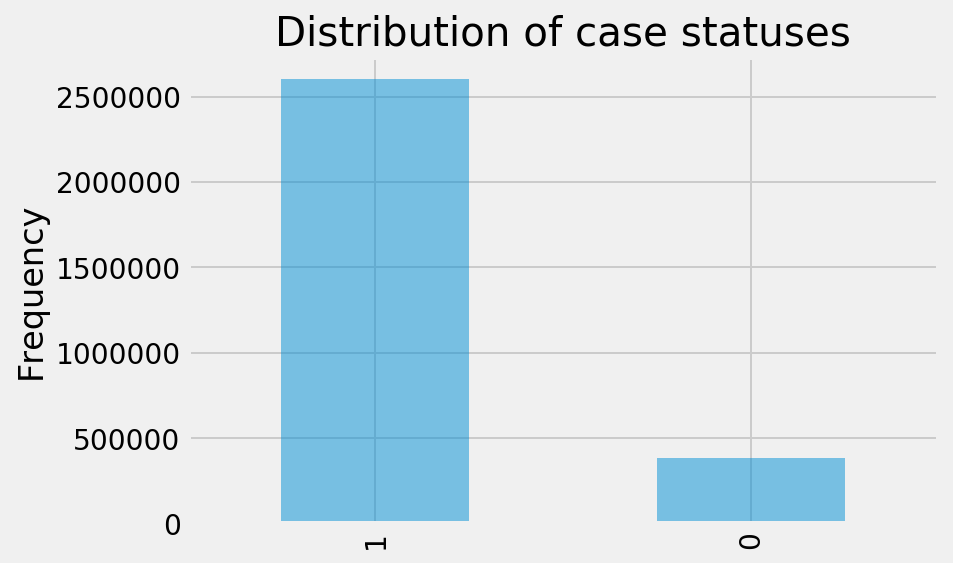

In [46]:
data['CASE_STATUS'].value_counts().plot(kind='bar', alpha=0.5)
plt.title('Distribution of case statuses')
plt.ylabel('Frequency');

In [47]:
# number of unique values in each column
for column in data:
    print(column, data[column].nunique())   

CASE_STATUS 2
SOC_NAME 1584
FULL_TIME_POSITION 2
PREVAILING_WAGE 56000
WORKSITE 53


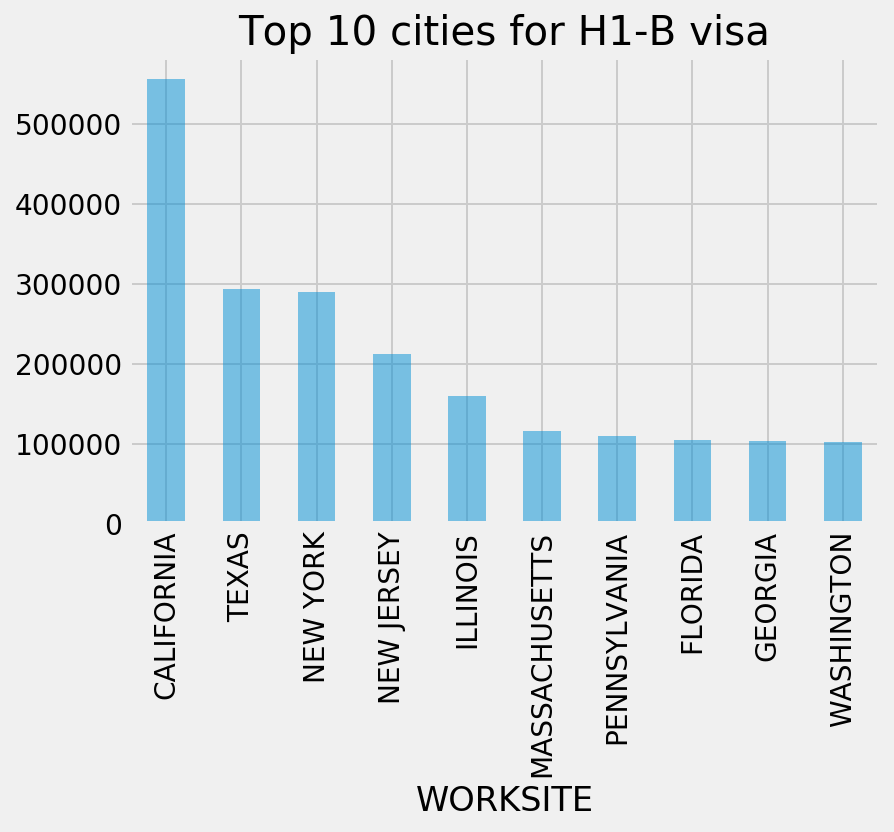

In [48]:
data['WORKSITE'].groupby(data['WORKSITE']).count()\
                .sort_values(ascending=False).head(10).plot(kind='bar', alpha=0.5)
plt.title('Top 10 cities for H1-B visa');

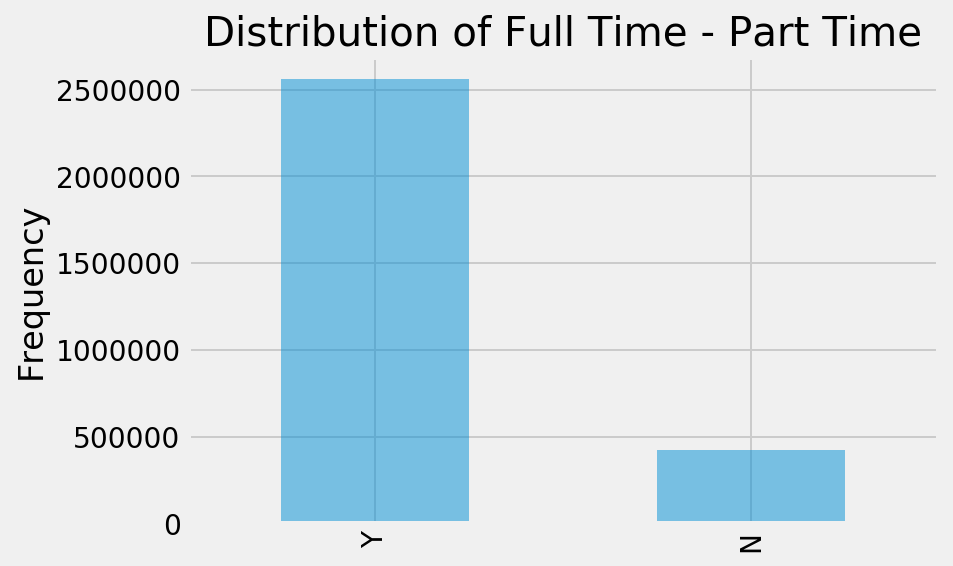

In [49]:
data['FULL_TIME_POSITION'].value_counts().plot(kind='bar', alpha=0.5)
plt.title('Distribution of Full Time - Part Time')
plt.ylabel('Frequency');

In [50]:
pd.options.display.float_format = '{:,.2f}'.format

data['PREVAILING_WAGE'].describe()

count       2,984,656.00
mean          146,964.65
std         5,296,105.34
min                 0.00
25%            54,350.00
50%            65,000.00
75%            81,432.00
max     6,997,606,720.00
Name: PREVAILING_WAGE, dtype: float64

Clearly, there are outliers in the dataset. Approxiametly, 12000 wages are below 25000 or above 500000, those records will be removed.

In [51]:
data[(data['PREVAILING_WAGE'] > 500000) | (data['PREVAILING_WAGE'] < 25000)].shape

(11978, 5)

In [52]:
cleaned_data = data[(data['PREVAILING_WAGE'] < 500000)]
cleaned_data = cleaned_data[(cleaned_data['PREVAILING_WAGE'] > 25000)]

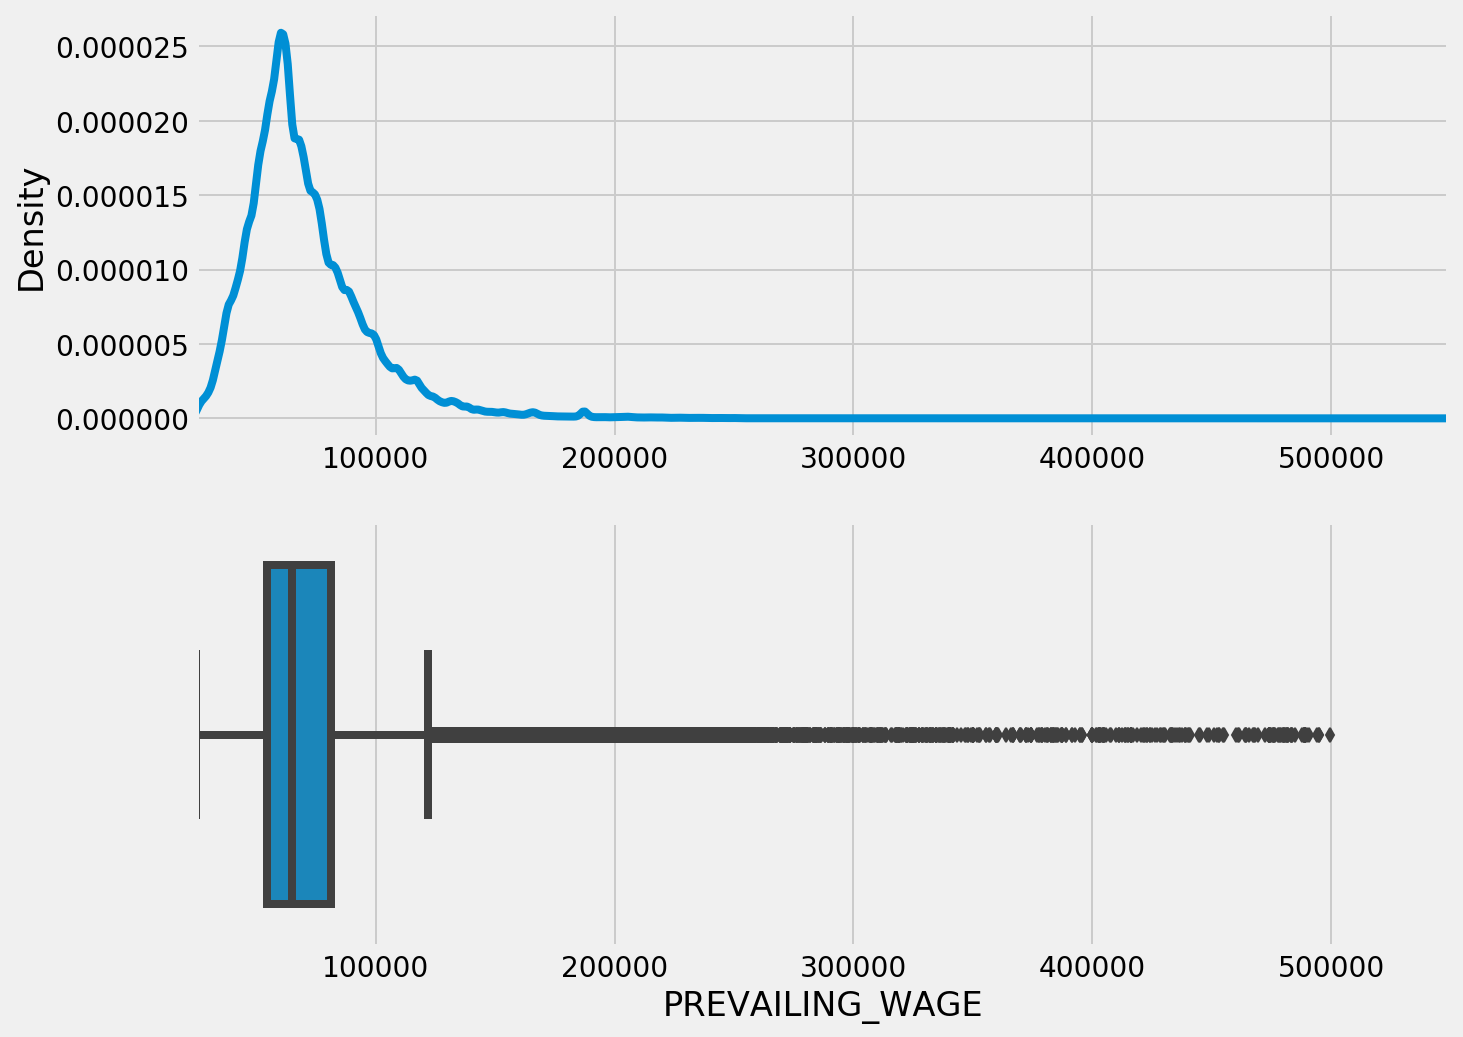

In [53]:
i = 'PREVAILING_WAGE'

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(cleaned_data[i].min(), cleaned_data[i].max()*1.1)

ax = cleaned_data[i].plot(kind='kde')

plt.subplot(212)
plt.xlim(cleaned_data[i].min(), cleaned_data[i].max()*1.1)
sns.boxplot(x=cleaned_data[i]);

Here we have two plots, the density plot and the box plot. This is a good way to view the data as we can see in the density plot (top) that there is some data points in the tails but it is difficult to see, however it is clear in the box plot.

### 4. Data Transforming

For highly sckewed features, it is always good to do transformation. **PREVAILING_WAGE** column has tail on the right and we will apply logarithmic transformation on it. 

In [54]:
# log transform the data
cleaned_data['Log_' + i] = np.log(cleaned_data[i])

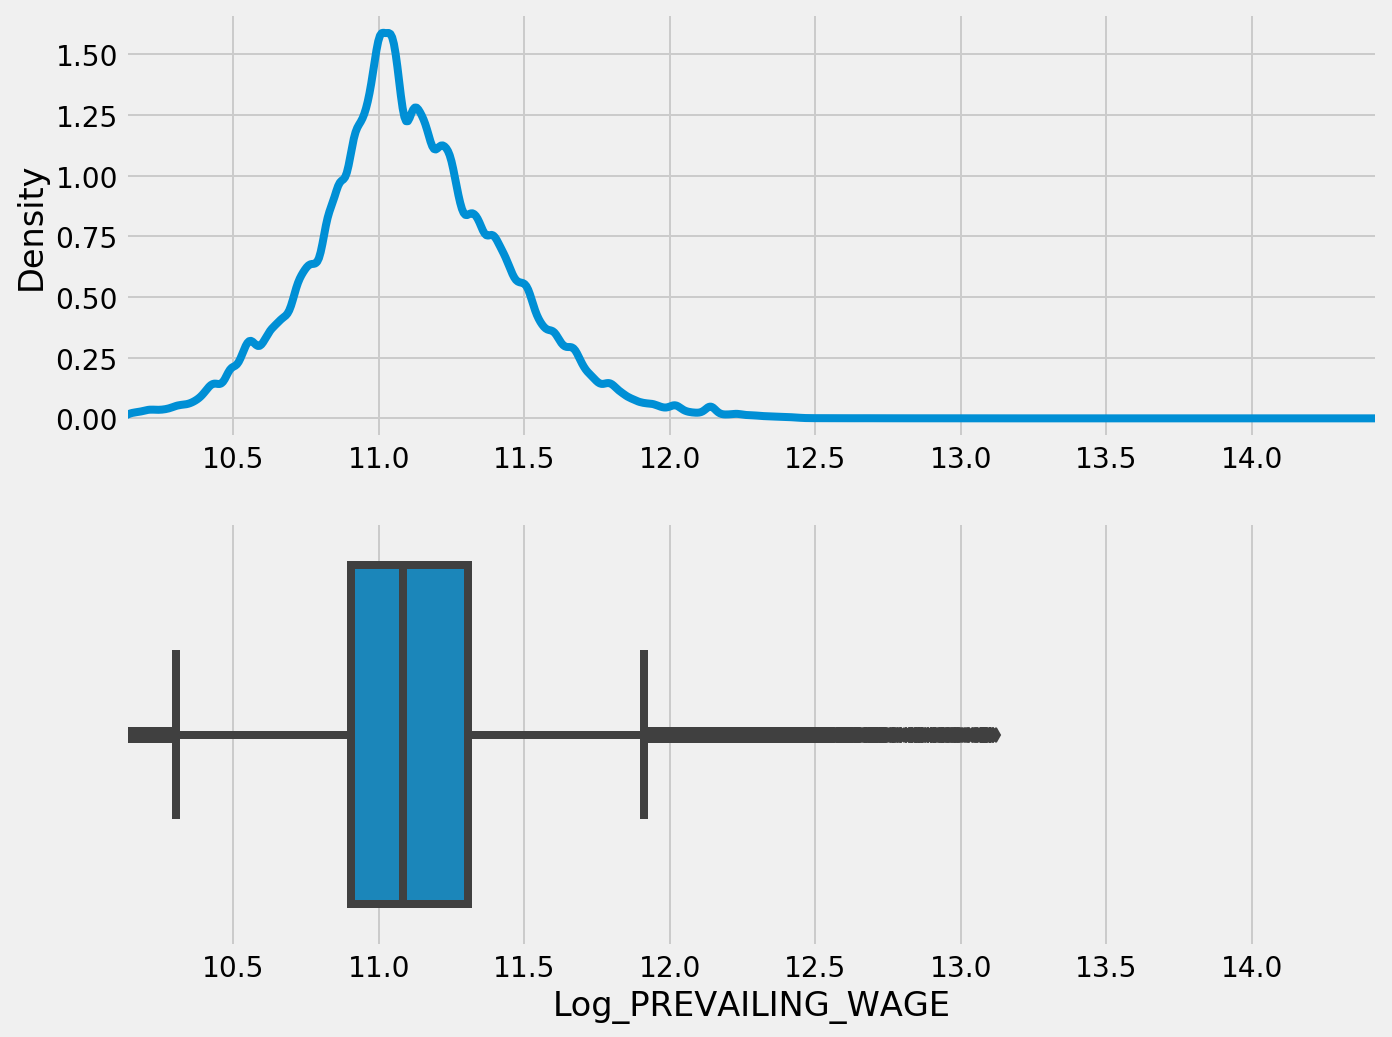

In [55]:
i = 'Log_PREVAILING_WAGE'

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(cleaned_data[i].min(), cleaned_data[i].max()*1.1)

ax = cleaned_data[i].plot(kind='kde')

plt.subplot(212)
plt.xlim(cleaned_data[i].min(), cleaned_data[i].max()*1.1)
sns.boxplot(x=cleaned_data[i]);

time to scale transformed data 

In [56]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['Log_PREVAILING_WAGE']

transformed_data = pd.DataFrame(data = cleaned_data)
transformed_data[numerical] = scaler.fit_transform(cleaned_data[numerical])

In [57]:
# remove original wage column 
del transformed_data['PREVAILING_WAGE']

In [58]:
transformed_data.head()

,CASE_STATUS,SOC_NAME,FULL_TIME_POSITION,WORKSITE,Log_PREVAILING_WAGE
1,0,BIOCHEMISTS AND BIOPHYSICISTS,N,MICHIGAN,0.12
2,0,CHIEF EXECUTIVES,Y,TEXAS,0.76
3,0,CHIEF EXECUTIVES,Y,NEW JERSEY,0.68
4,0,CHIEF EXECUTIVES,Y,COLORADO,0.73
5,0,CHIEF EXECUTIVES,Y,MISSOURI,0.61


4.1 Data Processing

In [59]:
# One-hot encode the transformed data using pandas.get_dummies()
features_final = pd.get_dummies(transformed_data, columns=['SOC_NAME', 'FULL_TIME_POSITION', 'WORKSITE'])

# 
df['FULL_TIME_POSITION'] = df['FULL_TIME_POSITION'].apply(lambda x: 1 if x == 'Y' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print ("total features after one-hot encoding: ", len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

total features after one-hot encoding:  1603


In [60]:
print ("Shape of final features: ", (features_final.shape))

#first 5 rows
features_final.head()

Shape of final features:  (2972647, 1603)


,CASE_STATUS,Log_PREVAILING_WAGE,SOC_NAME_13-2011.01,SOC_NAME_15-1121,SOC_NAME_15-1132,SOC_NAME_15-1199.01,SOC_NAME_15-1199.01 SW QUALITY ASSURANCE ENGNRS & TESTERS,"SOC_NAME_15-1199.08, BUSINESS INTELLIGENCE ANALYSTS",SOC_NAME_17-2051,SOC_NAME_17-2072,...,WORKSITE_SOUTH DAKOTA,WORKSITE_TENNESSEE,WORKSITE_TEXAS,WORKSITE_UTAH,WORKSITE_VERMONT,WORKSITE_VIRGINIA,WORKSITE_WASHINGTON,WORKSITE_WEST VIRGINIA,WORKSITE_WISCONSIN,WORKSITE_WYOMING
1,0,0.12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.76,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0.68,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0.61,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


4.2 Train-Test Split

In [61]:
X = features_final.iloc[:,1:]
y = features_final['CASE_STATUS']

In [62]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print ("Training set has samples: ", (X_train.shape[0]))
print ("Testing set has samples: ",  (X_test.shape[0]))

Training set has samples:  2378117
Testing set has samples:  594530


### 5. Data Modeling

### 6. Model Evaluation